In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from grand_slam_qf import *
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier, plot_tree, plot_importance
from lightgbm import LGBMClassifier 
import lightgbm as lgb      
import shap
from imblearn.under_sampling import TomekLinks,OneSidedSelection, RandomUnderSampler



/Users/barry/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def extract_qf_points(matches_df, points_df, qf_players):
    qf_match_ids = matches_df[
        matches_df['player1'].isin(qf_players) & matches_df['player2'].isin(qf_players)
    ]['match_id'].unique()
    return points_df[points_df['match_id'].isin(qf_match_ids)]




In [3]:
def get_df_from_csv(csv):
    return pd.read_csv(csv) 

## Get data and pre-process

In [4]:
matchesdf_us18 = get_df_from_csv("2018-usopen-matches.csv")
pointsdf_us18 = get_df_from_csv("2018-usopen-points.csv")

matchesdf_us19 = get_df_from_csv("2019-usopen-matches.csv")
pointsdf_us19 = get_df_from_csv("2019-usopen-points.csv")

matchesdf_us20 = get_df_from_csv("2020-usopen-matches.csv")
pointsdf_us20 = get_df_from_csv("2020-usopen-points.csv")

matchesdf_us21 = get_df_from_csv("2021-usopen-matches.csv")
pointsdf_us21 = get_df_from_csv("2021-usopen-points.csv")

matchesdf_us22 = get_df_from_csv("2022-usopen-matches.csv")
pointsdf_us22 = get_df_from_csv("2022-usopen-points.csv")

pointsdf_us23 = get_df_from_csv("2023-usopen-points.csv")

Extract Quartefinals onwards matches

In [5]:
# qf_points_usopen2018 = extract_qf_points(matchesdf_us18, pointsdf_us18, qf_usopen_2018)
qf_match_ids_2018 = [f"2018-usopen-{mid}" for mid in ['1501', '1502', '1503', '1504', '1601', '1602', '1701']]
qf_points_usopen2018 = pointsdf_us18[pointsdf_us18['match_id'].isin(qf_match_ids_2018)]
qf_match_ids_2019 = [f"2019-usopen-{mid}" for mid in ['1501', '1502', '1503', '1504', '1601', '1602', '1701']]
qf_points_usopen2019 = pointsdf_us19[pointsdf_us19['match_id'].isin(qf_match_ids_2019)]
qf_match_ids_2020 = [f"2020-usopen-{mid}" for mid in ['1501', '1502', '1503', '1504', '1601', '1602', '1701']]
qf_points_usopen2020 = pointsdf_us20[pointsdf_us20['match_id'].isin(qf_match_ids_2020)]
# qf_points_usopen2019 = extract_qf_points(matchesdf_us19, pointsdf_us19, qf_usopen_2019)
# qf_points_usopen2020 = extract_qf_points(matchesdf_us20, pointsdf_us20, qf_usopen_2020)
# # qf_points_usopen2021 = extract_qf_points(matchesdf_us21, pointsdf_us21, qf_usopen_2021)
#For some reason, the above code does not fully retrieve the points for the 2021 US Open quarterfinals, so I had to do it manually
#using match_ids
qf_match_ids_2021 = [f"2021-usopen-{mid}" for mid in ['1501', '1502', '1503', '1504', '1601', '1602', '1701']]
qf_points_usopen2021 = pointsdf_us21[pointsdf_us21['match_id'].isin(qf_match_ids_2021)]
# qf_points_usopen2022 = extract_qf_points(matchesdf_us22, pointsdf_us22, qf_usopen_2022)
qf_match_ids_2022 = [f"2022-usopen-{mid}" for mid in ['1501', '1502', '1503', '1504', '1601', '1602', '1701']]
qf_points_usopen2022 = pointsdf_us22[pointsdf_us22['match_id'].isin(qf_match_ids_2022)]
qf_points_usopen2023 = pointsdf_us23[pointsdf_us23['match_id'].isin(qf_match_ids_2023 := [f"2023-usopen-{mid}" for mid in ['1501', '1502', '1503', '1504', '1601', '1602', '1701']])]
print(qf_points_usopen2023.shape)
# print(qf_points_usopen2019.columns)


(1477, 65)


In [6]:
def drop_nan_columns(grandslam_points):
    nan_col = grandslam_points.columns[grandslam_points.isna().all()]
    grandslam_points = grandslam_points.drop(columns=nan_col)
    return grandslam_points
def drop_redundant_col (grandslam_points):
    grandslam_points = grandslam_points.drop(columns=['ElapsedTime', 'SetNo', 'GameNo', 'Speed_MPH','History'])
    return grandslam_points

## Data Visualization 

/Users/barry/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


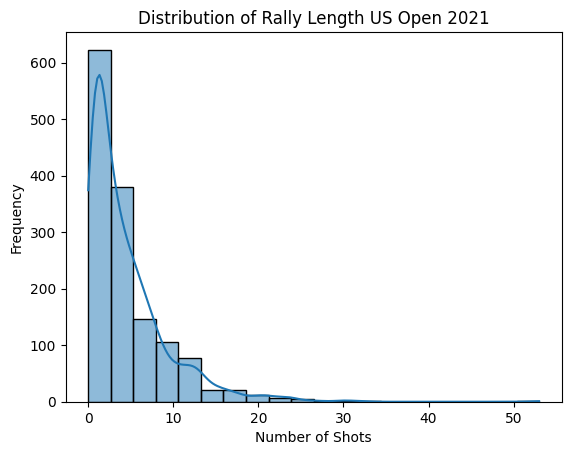

In [7]:
sns.histplot(data=qf_points_usopen2021, x="RallyCount", bins=20, kde=True)
plt.title("Distribution of Rally Length US Open 2021")
plt.xlabel("Number of Shots")
plt.ylabel("Frequency")
plt.show()

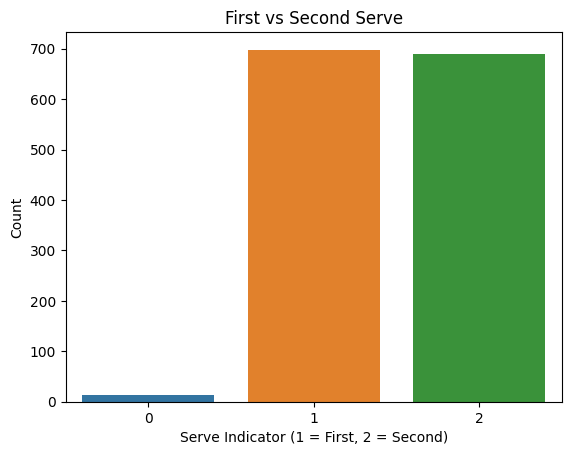

In [8]:
sns.countplot(data=qf_points_usopen2021, x="ServeIndicator")
plt.title("First vs Second Serve")
plt.xlabel("Serve Indicator (1 = First, 2 = Second)")
plt.ylabel("Count")
plt.show()

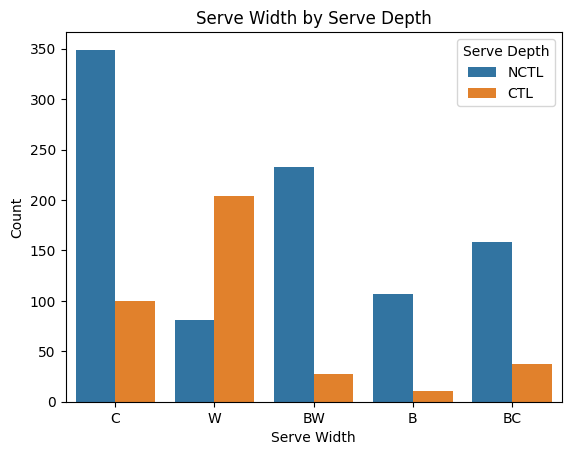

In [9]:
sns.countplot(data=qf_points_usopen2021, x="ServeWidth", hue="ServeDepth")
plt.title("Serve Width by Serve Depth")
plt.xlabel("Serve Width")
plt.ylabel("Count")
plt.legend(title="Serve Depth")
plt.show()

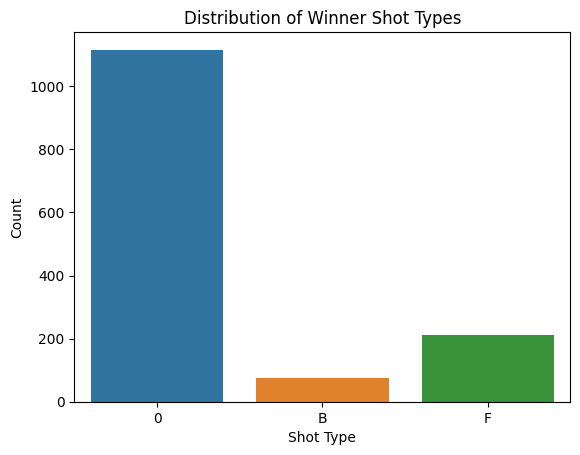

In [10]:
sns.countplot(data=qf_points_usopen2021, x="WinnerShotType")
plt.title("Distribution of Winner Shot Types")
plt.xlabel("Shot Type")
plt.ylabel("Count")
plt.show()


## Data Preprocessing

In [11]:
# Drop columns that are all NaN
qf_points_usopen2018_cleaned = drop_nan_columns(qf_points_usopen2018)
qf_points_usopen2018_cleaned = drop_redundant_col(qf_points_usopen2018_cleaned)
qf_points_usopen2019_cleaned = drop_nan_columns(qf_points_usopen2019)
qf_points_usopen2019_cleaned = drop_redundant_col(qf_points_usopen2019_cleaned)
# print(qf_points_usopen2018_cleaned.shape)
qf_points_usopen2020_cleaned = drop_nan_columns(qf_points_usopen2020)   
qf_points_usopen2020_cleaned = drop_redundant_col(qf_points_usopen2020_cleaned)
qf_points_usopen2021_cleaned = drop_nan_columns(qf_points_usopen2021)
qf_points_usopen2021_cleaned = drop_redundant_col(qf_points_usopen2021_cleaned)
qf_points_usopen2022_cleaned = drop_nan_columns(qf_points_usopen2022)
qf_points_usopen2022_cleaned = drop_redundant_col(qf_points_usopen2022_cleaned)
qf_points_usopen2023_cleaned = drop_nan_columns(qf_points_usopen2023)
qf_points_usopen2023_cleaned = drop_redundant_col(qf_points_usopen2023_cleaned)

# print(f"Total columns in qf_points_usopen2022_cleaned: {qf_points_usopen2022_cleaned.shape[1]}")

print(qf_points_usopen2023_cleaned.head(20))

               match_id  P1GamesWon  P2GamesWon  SetWinner  GameWinner  \
25932  2023-usopen-1501           0           0          0           0   
25933  2023-usopen-1501           0           0          0           0   
25934  2023-usopen-1501           0           0          0           0   
25935  2023-usopen-1501           0           0          0           0   
25936  2023-usopen-1501           0           0          0           0   
25937  2023-usopen-1501           0           0          0           0   
25938  2023-usopen-1501           0           0          0           0   
25939  2023-usopen-1501           1           0          0           1   
25940  2023-usopen-1501           1           0          0           0   
25941  2023-usopen-1501           1           0          0           0   
25942  2023-usopen-1501           1           0          0           0   
25943  2023-usopen-1501           1           0          0           0   
25944  2023-usopen-1501           1   

In [12]:
qf_points_usopen2018_cleaned['IsWinner'] = (qf_points_usopen2018_cleaned['WinnerType'] == 'S') | (qf_points_usopen2018_cleaned['WinnerShotType'].isin(['F', 'B']) )
print("Us Open 2018")
print(qf_points_usopen2018_cleaned['IsWinner'].value_counts())
qf_points_usopen2019_cleaned['IsWinner'] = (qf_points_usopen2019_cleaned['WinnerType'] == 'S') | (qf_points_usopen2019_cleaned['WinnerShotType'].isin(['F', 'B']) )
print("Us Open 2019")
print(qf_points_usopen2019_cleaned['IsWinner'].value_counts())
qf_points_usopen2020_cleaned['IsWinner'] = (qf_points_usopen2020_cleaned['WinnerType'] == 'S') | (qf_points_usopen2020_cleaned['WinnerShotType'].isin(['F', 'B']) )
print("US Open 2020")
print(qf_points_usopen2020_cleaned['IsWinner'].value_counts())
qf_points_usopen2021_cleaned['IsWinner'] = (qf_points_usopen2021_cleaned['WinnerType'] == 'S') | (qf_points_usopen2021_cleaned['WinnerShotType'].isin(['F', 'B']) )
print("Us Open 2021")
print(qf_points_usopen2021_cleaned['IsWinner'].value_counts())
qf_points_usopen2022_cleaned['IsWinner'] = (qf_points_usopen2022_cleaned['WinnerType'] == 'S') | (qf_points_usopen2022_cleaned['WinnerShotType'].isin(['F', 'B']) )
print("Us Open 2022")
print(qf_points_usopen2022_cleaned['IsWinner'].value_counts())
qf_points_usopen2023_cleaned['IsWinner'] = (qf_points_usopen2023_cleaned['WinnerType'] == 'S') | (qf_points_usopen2023_cleaned['WinnerShotType'].isin(['F', 'B']) )
print("US Open 2023", qf_points_usopen2023_cleaned['IsWinner'].value_counts())
temp = qf_points_usopen2018_cleaned['IsWinner'].value_counts() + qf_points_usopen2019_cleaned['IsWinner'].value_counts() + \
       qf_points_usopen2020_cleaned['IsWinner'].value_counts() + qf_points_usopen2021_cleaned['IsWinner'].value_counts() + \
       qf_points_usopen2022_cleaned['IsWinner'].value_counts()
print("Total winners 18-22:")

print(temp)


Us Open 2018
IsWinner
False    1202
True      434
Name: count, dtype: int64
Us Open 2019
IsWinner
False    1326
True      459
Name: count, dtype: int64
US Open 2020
IsWinner
False    1376
True      430
Name: count, dtype: int64
Us Open 2021
IsWinner
False    1088
True      313
Name: count, dtype: int64
Us Open 2022
IsWinner
False    1422
True      510
Name: count, dtype: int64
US Open 2023 IsWinner
False    1102
True      375
Name: count, dtype: int64
Total winners 18-22:
IsWinner
False    6414
True     2146
Name: count, dtype: int64


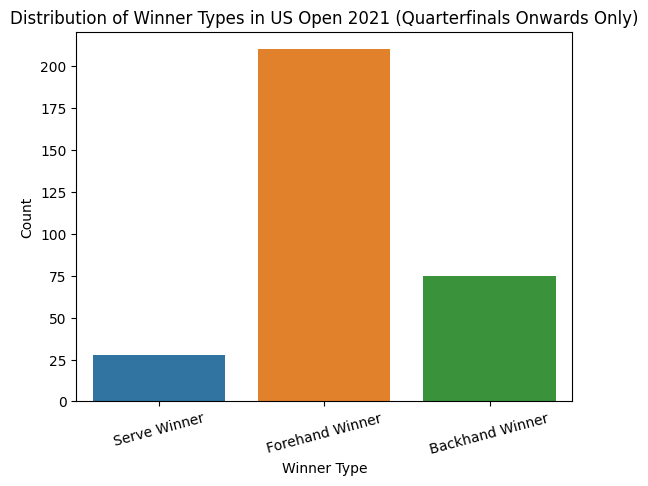

In [13]:
# Create a new column to label winner shot type
def classify_winner(row):
    if row["WinnerType"] == "S":
        return "Serve Winner"
    elif row["WinnerShotType"] == "F":
        return "Forehand Winner"
    elif row["WinnerShotType"] == "B":
        return "Backhand Winner"
    else:
        return None

# Apply classification
qfdraft = qf_points_usopen2021_cleaned.copy()
qfdraft["IsWinner"] = qf_points_usopen2021_cleaned.apply(classify_winner, axis=1)

# Filter only actual winners
winner_points = qfdraft[qfdraft["IsWinner"].notna()]

# Plot
sns.countplot(data=winner_points, x="IsWinner", order=["Serve Winner", "Forehand Winner", "Backhand Winner"])
plt.title("Distribution of Winner Types in US Open 2021 (Quarterfinals Onwards Only)")
plt.xlabel("Winner Type")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.show()


In [14]:
# sns.boxplot(data=qf_points_usopen2021_cleaned, x="IsWinner", y="RallyCount")
# plt.title("Rally Length by Winner Outcome")
# plt.xlabel("Point Ended in Winner")
# plt.ylabel("Rally Length")
# plt.show()


In [15]:
# qf_points_usopen2019_cleaned.isnull().sum()
# nan_data = qf_points_usopen2019_cleaned[
#     qf_points_usopen2019_cleaned[['ServeWidth', 'ServeDepth', 'ReturnDepth']].isna().all(axis=1)
# ]
# print(nan_data)

### One-hot coding on ServeWidth, ServeDepth, and ReturnDepth

In [16]:
columns = ['ServeWidth', 'ServeDepth', 'ReturnDepth']
categories = [
        ['B', 'BC', 'BW', 'C', 'W', 'Missing'],
        ['CTL', 'NCTL', 'Missing'],
        ['D', 'ND', 'Missing']
    ]
def ohencode_categorical_features(dataframe, columns, categories):
    # Create a copy to preserve original
    cat_encoded = dataframe[columns].copy()

    # Fill missing values with placeholder for categorical encoding
    cat_encoded.fillna('Missing', inplace=True)

    # Initialize OneHotEncoder with known categories
    encoder = OneHotEncoder(
        categories=categories,
        sparse_output=False,
        handle_unknown='ignore'
    )

    # Fit and transform the data
    encoded_array = encoder.fit_transform(cat_encoded)

    # Retrieve new column names
    encoded_columns = encoder.get_feature_names_out(columns)

    # Create encoded DataFrame
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns, index=dataframe.index)
    return encoded_df

In [17]:
qf_points_usopen2018_encoded = ohencode_categorical_features(qf_points_usopen2018_cleaned, columns, categories)
qf_points_usopen2019_encoded = ohencode_categorical_features(qf_points_usopen2019_cleaned, columns, categories)
qf_points_usopen2020_encoded = ohencode_categorical_features(qf_points_usopen2020_cleaned, columns, categories)
qf_points_usopen2021_encoded = ohencode_categorical_features(qf_points_usopen2021_cleaned, columns, categories)
qf_points_usopen2022_encoded = ohencode_categorical_features(qf_points_usopen2022_cleaned, columns, categories)
qf_points_usopen2023_encoded = ohencode_categorical_features(qf_points_usopen2023_cleaned, columns, categories)

In [18]:

# # Create a copy to preserve original
# cat_encoded = qf_points_usopen2019_cleaned[['ServeWidth', 'ServeDepth', 'ReturnDepth']].copy()

# # Fill missing values with placeholder for categorical encoding
# cat_encoded.fillna('Missing', inplace=True)

# # Initialize OneHotEncoder with known categories
# encoder = OneHotEncoder(
#     categories=[
#         ['B', 'BC', 'BW', 'C', 'W', 'Missing'],
#         ['CTL', 'NCTL', 'Missing'],
#         ['D', 'ND', 'Missing']
#     ],
#     sparse_output =False,
#     handle_unknown='ignore'
# )

# # Fit and transform the data
# encoded_array = encoder.fit_transform(cat_encoded)

# # Retrieve new column names
# encoded_columns = encoder.get_feature_names_out(['ServeWidth', 'ServeDepth', 'ReturnDepth'])

# # Create encoded DataFrame
# encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns, index=qf_points_usopen2019_cleaned.index)
# encoded_df.head()

In [19]:
# qf_encoded.isnull().sum()
# # Count the number of columns in the DataFrame
# print(f"Total columns in qf_encoded: {qf_encoded.shape[1]}")
# qf_encoded.columns
# qf_encoded['IsWinner'].value_counts()

## Selecting Features and Modelling

In [20]:
# Select relevant features for the model
refined_features = [
    'Speed_KMH', 
    # 'P1Momentum', 'P2Momentum',
    # 'MomentumDiff',
    'P1Ace', 'P2Ace',
    'AceDiff',
    'P1UnfErr', 'P2UnfErr',
    'UnfErrDiff',
    'P1NetPoint', 'P2NetPoint',
    'NetDominance',
    'P1BreakPoint', 'P2BreakPoint',
    'P1BreakPointMissed', 'P2BreakPointMissed',
    'ServeIndicator', 'ServeNumber',
    'P1DistanceRun', 'P2DistanceRun',
    'RallyCount',
    'ServeWidth_B', 'ServeWidth_BC', 'ServeWidth_BW', 'ServeWidth_C', 'ServeWidth_W', 'ServeWidth_Missing',
    'ServeDepth_CTL', 'ServeDepth_NCTL', 'ServeDepth_Missing',
    'ReturnDepth_D', 'ReturnDepth_ND', 'ReturnDepth_Missing',
    'Speed_Width_W', 
    # 'Rally_NetDom', 
    'DistanceDiff'
]


## Prepare data for model

In [21]:
full_data_p1 = pd.concat([qf_points_usopen2018_cleaned.reset_index(drop=True), qf_points_usopen2018_encoded.reset_index(drop=True)], axis=1)
full_data_p2 = pd.concat([qf_points_usopen2019_cleaned.reset_index(drop=True), qf_points_usopen2019_encoded.reset_index(drop=True)], axis=1)
full_data_p3 = pd.concat([qf_points_usopen2020_cleaned.reset_index(drop=True), qf_points_usopen2020_encoded.reset_index(drop=True)], axis=1)
full_data_p4 = pd.concat([qf_points_usopen2021_cleaned.reset_index(drop=True), qf_points_usopen2021_encoded.reset_index(drop=True)], axis=1)
full_data_p5 = pd.concat([qf_points_usopen2022_cleaned.reset_index(drop=True), qf_points_usopen2022_encoded.reset_index(drop=True)], axis=1)
# print(full_data_p2.isnull().sum())
# Combine both datasets
test_data = pd.concat([qf_points_usopen2023_cleaned.reset_index(drop=True), qf_points_usopen2023_encoded.reset_index(drop=True)], axis=1)
full_data = pd.concat([full_data_p1, full_data_p2,full_data_p3, full_data_p4, full_data_p5], ignore_index=True)
# # Engineered feature construction
# full_data['MomentumDiff'] = full_data['P1Momentum'] - full_data['P2Momentum']
full_data['DistanceDiff'] = full_data['P1DistanceRun'] - full_data['P2DistanceRun']
full_data['AceDiff'] = full_data['P1Ace'] - full_data['P2Ace']
full_data['NetDominance'] = full_data['P1NetPoint'] - full_data['P2NetPoint']
full_data['UnfErrDiff'] = full_data['P1UnfErr'] - full_data['P2UnfErr']
# Add interaction terms
full_data['Speed_Width_W'] = full_data['Speed_KMH'] * full_data.get('ServeWidth_W', 0)
# full_data['Rally_NetDom'] = full_data['RallyCount'] * full_data['NetDominance']
# Feature engineering for test data
# test_data['MomentumDiff'] = test_data['P1Momentum'] - test_data['P2Momentum']
test_data['DistanceDiff'] = test_data['P1DistanceRun'] - test_data['P2DistanceRun']
test_data['AceDiff'] = test_data['P1Ace'] - test_data['P2Ace']
test_data['NetDominance'] = test_data['P1NetPoint'] - test_data['P2NetPoint']
test_data['UnfErrDiff'] = test_data['P1UnfErr'] - test_data['P2UnfErr']
test_data['Speed_Width_W'] = test_data['Speed_KMH'] * test_data.get('ServeWidth_W', 0)
# test_data['Rally_NetDom'] = test_data['RallyCount'] * test_data['NetDominance']
# Ensure 'IsWinner' is in the final DataFrame
full_data['IsWinner'] = full_data['IsWinner'].astype(int)
test_data['IsWinner'] = test_data['IsWinner'].astype(int)
# Select only the relevant features and the target variable
model_ready_data = full_data[refined_features + ['IsWinner']].dropna()
test_ready_data = test_data[refined_features + ['IsWinner']].dropna()
print(model_ready_data.shape)
# print(test_data.isnull().sum())
print(test_ready_data.shape)
print(test_ready_data['IsWinner'].value_counts())

(8560, 34)
(1477, 34)
IsWinner
0    1102
1     375
Name: count, dtype: int64


In [22]:
model_ready_data.head(10)

Speed_KMH  P1Ace  P2Ace  AceDiff  P1UnfErr  P2UnfErr  UnfErrDiff  \
0          0      0      0        0         0         0           0   
1          0      0      0        0         0         0           0   
2        154      0      0        0         1         0           1   
3        167      0      0        0         0         0           0   
4        191      0      0        0         0         0           0   
5        186      0      0        0         0         0           0   
6        151      0      0        0         0         0           0   
7        160      0      0        0         1         0           1   
8          0      0      0        0         0         1          -1   
9        164      0      0        0         0         0           0   

   P1NetPoint  P2NetPoint  NetDominance  ...  ServeWidth_Missing  \
0           0           0             0  ...                 1.0   
1           0           0             0  ...                 1.0   
2           0           0             0  ...                 0.0   
3           0           0             0  ...                 0.0   
4           0           0             0  ...                 0.0   
5           0           0             0  ...                 0.0   
6           0           0             0  ...                 0.0   
7           0           0             0  ...                 0.0   
8           0           0             0  ...                 1.0   
9           0           0             0  ...                 0.0   

   ServeDepth_CTL  ServeDepth_NCTL  ServeDepth_Missing  ReturnDepth_D  \
0             0.0              0.0                 1.0            0.0   
1             0.0              0.0                 1.0            0.0   
2             0.0              1.0                 0.0            0.0   
3             0.0              1.0                 0.0            1.0   
4             0.0              1.0                 0.0            1.0   
5             0.0              1.0                 0.0            0.0   
6             0.0              1.0                 0.0            0.0   
7             0.0              1.0                 0.0            1.0   
8             0.0              0.0                 1.0            0.0   
9             0.0              1.0                 0.0            1.0   

   ReturnDepth_ND  ReturnDepth_Missing  Speed_Width_W  DistanceDiff  IsWinner  
0             0.0                  1.0            0.0         0.000         0  
1             0.0                  1.0            0.0         0.000         0  
2             1.0                  0.0            0.0       -27.834         0  
3             0.0                  0.0          167.0        -6.730         1  
4             0.0                  0.0            0.0         0.792         0  
5             1.0                  0.0            0.0         1.788         0  
6             1.0                  0.0            0.0        -5.538         1  
7             0.0                  0.0            0.0         6.566         0  
8             0.0                  1.0            0.0         0.184         0  
9             0.0                  0.0            0.0         1.970         1  

[10 rows x 34 columns]

## Logistic Regression model

In [23]:
X = model_ready_data[refined_features]
y = (model_ready_data['IsWinner']).astype(int)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
tomek = TomekLinks(sampling_strategy='majority')
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train, y_train)
print("Before Tomek:", y_train.value_counts())
print("After Tomek Links:", y_train_tomek.value_counts())
smote = SMOTE(sampling_strategy={1: 6000} ,random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tomek, y_train_tomek)
print("After SMOTE:", y_train_resampled.value_counts())
# tomek_post = TomekLinks(sampling_strategy='majority')
# X_final, y_final = tomek_post.fit_resample(X_train_resampled, y_train_resampled)
# print("After Tomek Links Post SMOTE:", y_final.value_counts())
# tomek = TomekLinks()
# X_train_resampled, y_train_resampled = tomek.fit_resample(X_train_smote, y_train_smote)
logreg = LogisticRegression(max_iter=5000, class_weight='balanced', penalty='l1', solver='saga')
logreg.fit(X_train_resampled, y_train_resampled)
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]
report = classification_report(y_test, y_pred, output_dict=True)
auc = roc_auc_score(y_test, y_prob)
logreg_report_df = pd.DataFrame(report).transpose()
print("Logistic Regression Model Performance:")
print(logreg_report_df)
print("auc score: " + str(auc))


Before Tomek: IsWinner
0    5131
1    1717
Name: count, dtype: int64
After Tomek Links: IsWinner
0    4760
1    1717
Name: count, dtype: int64
After SMOTE: IsWinner
1    6000
0    4760
Name: count, dtype: int64
Logistic Regression Model Performance:
              precision    recall  f1-score      support
0              0.953695  0.754482  0.842472  1283.000000
1              0.548063  0.890443  0.678508   429.000000
accuracy       0.788551  0.788551  0.788551     0.788551
macro avg      0.750879  0.822462  0.760490  1712.000000
weighted avg   0.852050  0.788551  0.801385  1712.000000
auc score: 0.8806301518694349


### Visualise LogReg Model result

In [ ]:
coefficients = pd.Series(logreg.coef_[0], index=X_train_resampled.columns).sort_values(ascending=False)
cm = confusion_matrix(y_test, y_pred)
coefficients.head(5), coefficients.tail(5), cm

(RallyCount        2.188942
 Speed_Width_W     0.607027
 ReturnDepth_ND    0.426763
 P2NetPoint        0.408983
 P1NetPoint        0.355991
 Speed_KMH         0.333508
 ServeWidth_BW     0.125206
 ServeWidth_C      0.099458
 ServeWidth_B      0.069217
 ServeIndicator    0.063621
 dtype: float64,
 ServeWidth_BC        -0.076912
 ServeWidth_Missing   -0.096595
 ServeDepth_Missing   -0.096595
 ServeWidth_W         -0.504043
 P2DistanceRun        -0.822433
 P1DistanceRun        -0.837623
 P1Ace                -1.389918
 P2Ace                -1.533714
 P2UnfErr             -3.650077
 P1UnfErr             -4.494562
 dtype: float64,
 array([[968, 315],
        [ 47, 382]]))

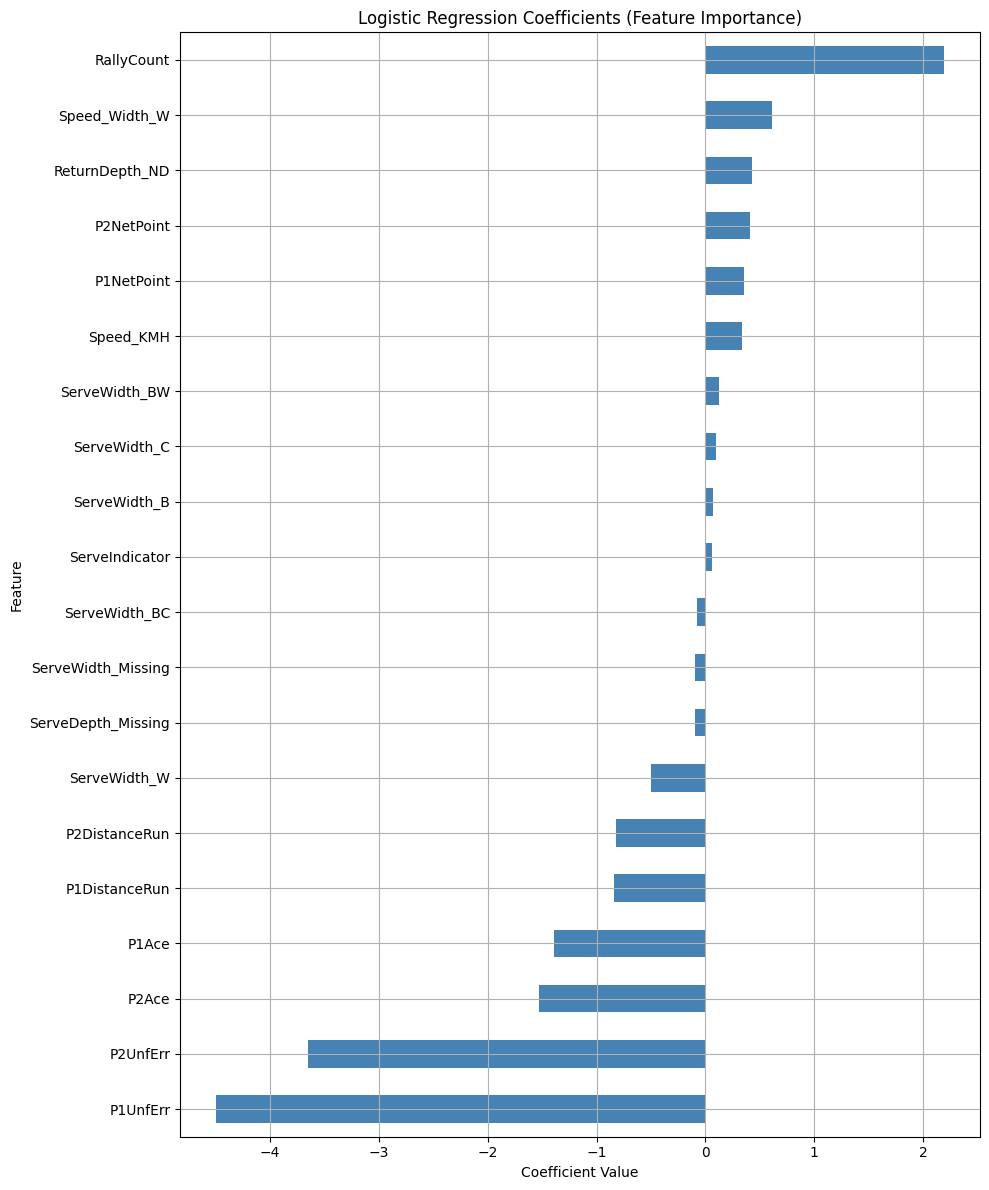

In [57]:
top_bottom_features = pd.concat([coefficients.head(10), coefficients.tail(10)])
plt.figure(figsize=(10, 12))
top_bottom_features.sort_values().plot(kind='barh', color='steelblue')
plt.title('Logistic Regression Coefficients (Feature Importance)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()

## Random Forest 

In [26]:
from sklearn.ensemble import RandomForestClassifier
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)
X = model_ready_data[refined_features]
y = (model_ready_data['IsWinner']).astype(int)
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
print(X_scaled.shape)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)
smote = SMOTE(sampling_strategy = 0.8 ,random_state=42)
tomek = TomekLinks(sampling_strategy='majority')
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tomek, y_train_tomek)
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]
report = classification_report(y_test, y_pred, output_dict=True)
auc = roc_auc_score(y_test, y_prob)
rf_report_df = pd.DataFrame(report).transpose()
print("Random Forest Model Performance:")
print(rf_report_df)
print("auc score: " + str(auc))

(8560, 33)
Random Forest Model Performance:
              precision    recall  f1-score      support
0              0.952199  0.776306  0.855303  1283.000000
1              0.569069  0.883450  0.692237   429.000000
accuracy       0.803154  0.803154  0.803154     0.803154
macro avg      0.760634  0.829878  0.773770  1712.000000
weighted avg   0.856193  0.803154  0.814441  1712.000000
auc score: 0.9042653890666361


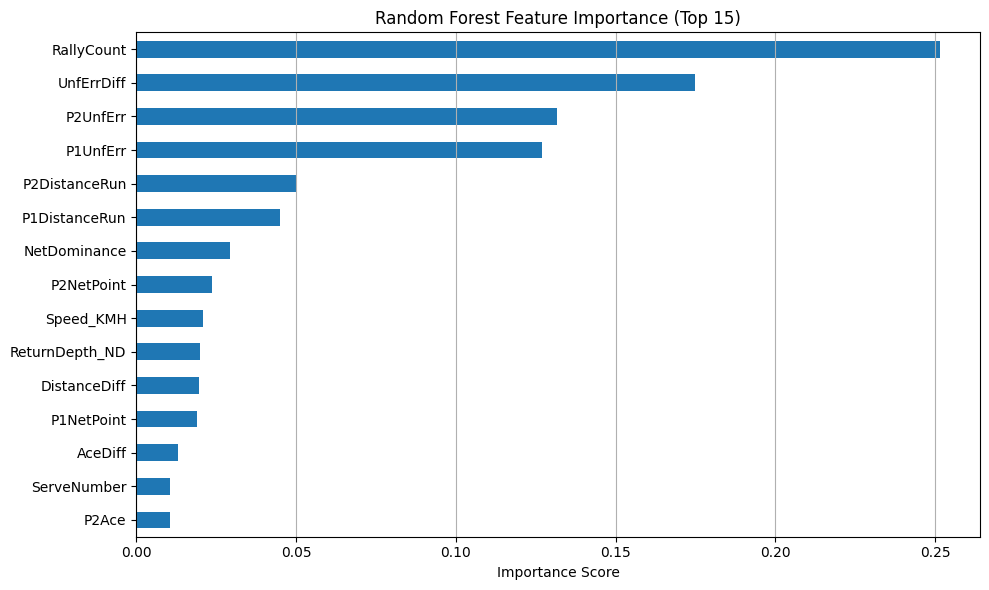

In [53]:
rf_importance = pd.Series(rf_model.feature_importances_, index=X_train_resampled.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
rf_importance.head(15).plot(kind='barh')
plt.title("Random Forest Feature Importance (Top 15)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

## xGBoost + lightGradientBM

In [27]:
X = model_ready_data[refined_features]
y = (model_ready_data['IsWinner']).astype(int)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
# scale_pos_weight = (y_train == 1).sum() / (y_train == 0).sum()
print("Before Tomek:", y_train.value_counts())
tomek = TomekLinks(sampling_strategy='majority')
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train, y_train)
print("After Tomek Links:", y_train_tomek.value_counts())
smote = SMOTE(sampling_strategy={1: 6000} ,random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tomek, y_train_tomek)
print("After SMOTE:", y_train_resampled.value_counts())
# Apply Tomek Links again to the resampled data
# tomek2 = TomekLinks(sampling_strategy='auto')
# X_train_resampled, y_train_resampled = tomek2.fit_resample(X_train_resampled, y_train_resampled)
# print("After 2 tomek Links:", y_train_resampled.value_counts())
param_dist = {
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'min_split_gain': [0, 0.1, 0.2],
    'scale_pos_weight': [1, 2, 5, 10, 20, 50]
}

f1_scorer = make_scorer(f1_score, pos_label=1)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lgb_model = LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    n_estimators=200,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=25,
    scoring=f1_scorer,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train_resampled, y_train_resampled)
best_params = random_search.best_params_
best_score = random_search.best_score_
# best_params, best_score

# final_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
lgbm_model = LGBMClassifier(**best_params, random_state=42)
lgbm_model.fit(X_train_resampled, y_train_resampled)
y_prob_lgbm = lgbm_model.predict_proba(X_test)[:, 1]
# Finding best threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_lgbm)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold_lgbm = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
# threshold = 0.42  # or re-tune this
y_pred = (y_prob_lgbm >= best_threshold_lgbm).astype(int) #Model prediction using the best threshold
final_report = classification_report(y_test, y_pred, output_dict=True)
lgb_report_df = pd.DataFrame(final_report).transpose()
print("LGBM Model Performance:")
print(lgb_report_df)

Before Tomek: IsWinner
0    5131
1    1717
Name: count, dtype: int64
After Tomek Links: IsWinner
0    4760
1    1717
Name: count, dtype: int64
After SMOTE: IsWinner
1    6000
0    4760
Name: count, dtype: int64
Fitting 3 folds for each of 25 candidates, totalling 75 fits


/Users/barry/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/barry/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/barry/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/barry/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/barry/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas require

[LightGBM] [Info] Number of positive: 4000, number of negative: 3173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2375
[LightGBM] [Info] Number of data points in the train set: 7173, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.557647 -> initscore=0.231617
[LightGBM] [Info] Start training from score 0.231617
[LightGBM] [Info] Number of positive: 4000, number of negative: 3173
[LightGBM] [Info] Number of positive: 4000, number of negative: 3174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2095
[LightGBM] [Info] Number of data points in the tr

AUC Score: 0.9108


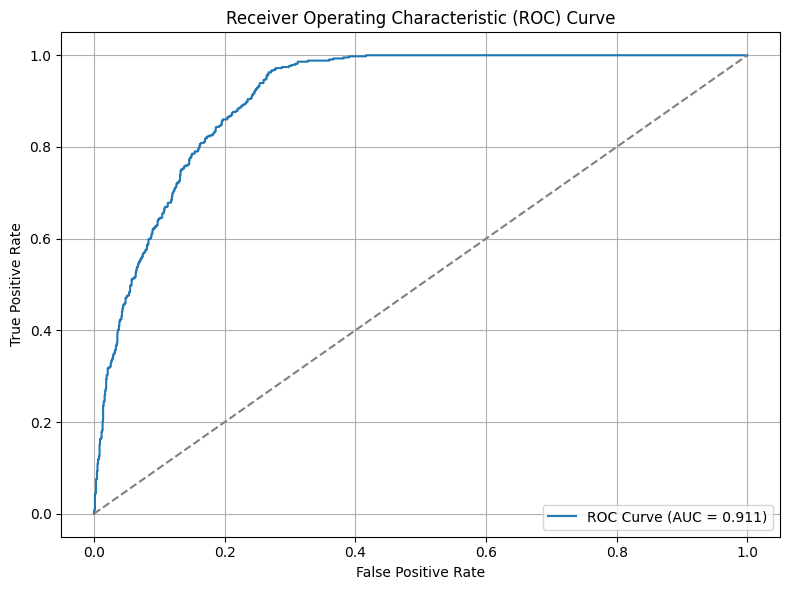

In [28]:
auc_score = roc_auc_score(y_test, y_prob_lgbm)
# auc = roc_auc_score(y_test, y_prob_lgbm)
print(f"AUC Score: {auc_score:.4f}")
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob_lgbm)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

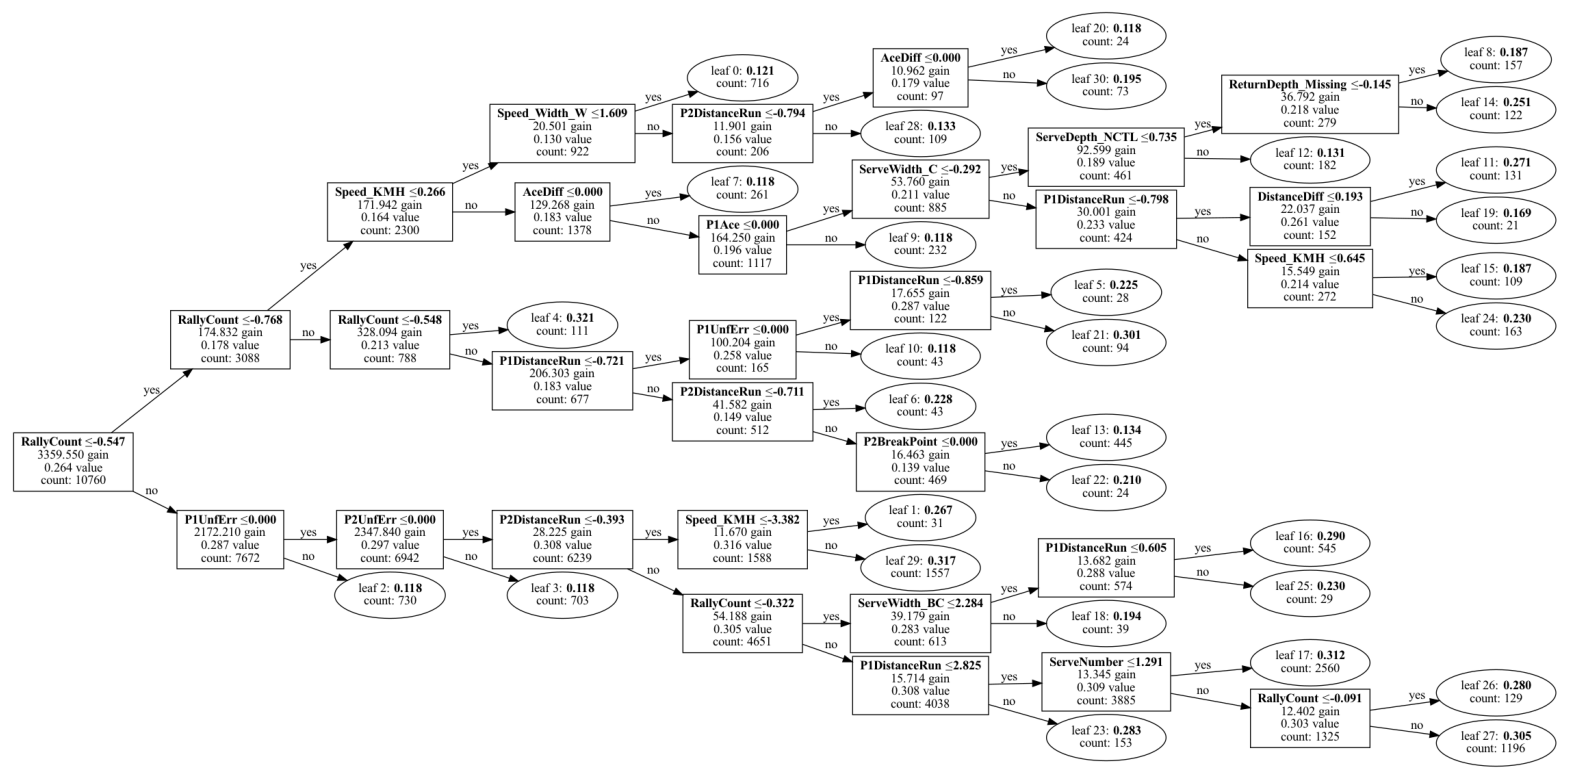

In [29]:
ax = lgb.plot_tree(lgbm_model, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
plt.show()

In [30]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=25,
    scoring=f1_scorer,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train_resampled, y_train_resampled)
best_params = random_search.best_params_
xgb_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_resampled, y_train_resampled)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
# Finding best threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold_xgb = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
# threshold = 0.42  # or re-tune this
y_pred = (y_prob_xgb >= best_threshold_xgb).astype(int) #Model prediction using the best threshold
final_report = classification_report(y_test, y_pred, output_dict=True)
xgb_report_df = pd.DataFrame(final_report).transpose()
print("XGBoost Model Performance:")
print(xgb_report_df)
auc = roc_auc_score(y_test, y_prob_xgb)
print("auc score: " + str(auc))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, min_child_weight=5, min_split_gain=0, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, min_child_weight=5, min_split_gain=0, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, min_child_weight=5, min_split_gain=0, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   0.2s


/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=3, min_split_gain=0.1, n_estimators=200, scale_pos_weight=10, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=3, min_split_gain=0.1, n_estimators=200, scale_pos_weight=10, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=3, min_split_gain=0.1, n_estimators=200, scale_pos_weight=10, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, min_split_gain=0, n_estimators=300, scale_pos_weight=20, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, min_split_gain=0, n_estimators=300, scale_pos_weight=20, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=5, min_split_gain=0, n_estimators=300, sc

/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_gain=0, n_estimators=300, scale_pos_weight=5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, min_child_weight=3, min_split_gain=0.1, n_estimators=200, scale_pos_weight=20, subsample=1.0; total time=   0.1s


/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, min_child_weight=3, min_split_gain=0, n_estimators=200, scale_pos_weight=10, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, min_child_weight=3, min_split_gain=0, n_estimators=200, scale_pos_weight=10, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, min_child_weight=3, min_split_gain=0.2, n_estimators=200, scale_pos_weight=20, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, min_child_weight=3, min_split_gain=0.2, n_estimators=200, scale_pos_weight=20, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, min_child_weight=3, min_split_gain=0.1, n_estimators=200, scale_pos_weight=20, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, min_child_weight=3, min_split_gain=0, n_estimators=200,

/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, min_child_weight=5, min_split_gain=0, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, min_child_weight=5, min_split_gain=0.2, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, min_child_weight=3, min_split_gain=0.1, n_estimators=200, scale_pos_weight=20, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, min_child_weight=5, min_split_gain=0, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, min_child_weight=3, min_split_gain=0.2, n_estimators=200, scale_pos_weight=20, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, min_child_weight=5, min_split_gain=0, n_estimators=100, scale_

/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, min_split_gain=0.1, n_estimators=300, scale_pos_weight=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, min_child_weight=1, min_split_gain=0.1, n_estimators=300, scale_pos_weight=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=8, min_child_weight=5, min_split_gain=0, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=8, min_child_weight=5, min_split_gain=0, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=8, min_child_weight=1, min_split_gain=0, n_estimators=300, scale_pos_weight=50, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=8, min_child_weight=5, min_split_gain=0, n_estimators=100, scal

/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, min_child_weight=3, min_split_gain=0.2, n_estimators=300, scale_pos_weight=20, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, min_split_gain=0, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, min_child_weight=1, min_split_gain=0.1, n_estimators=300, scale_pos_weight=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, min_split_gain=0, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, min_split_gain=0.2, n_estimators=100, scale_pos_weight=10, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=8, min_child_weight=1, min_split_gain=0, n_estimators=300, scal

/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, min_split_gain=0.2, n_estimators=100, scale_pos_weight=10, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, min_child_weight=3, min_split_gain=0.2, n_estimators=300, scale_pos_weight=20, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, min_split_gain=0, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, min_child_weight=1, min_split_gain=0.1, n_estimators=300, scale_pos_weight=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, min_child_weight=3, min_split_gain=0.2, n_estimators=300, scale_pos_weight=20, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=5, min_split_gain=0.2, n_estimators=300, s

/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, min_split_gain=0.1, n_estimators=100, scale_pos_weight=10, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=3, min_split_gain=0.2, n_estimators=100, scale_pos_weight=20, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=3, min_split_gain=0.1, n_estimators=100, scale_pos_weight=10, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=8, min_child_weight=1, min_split_gain=0, n_estimators=300, scale_pos_weight=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=5, min_split_gain=0.2, n_estimators=300, scale_pos_weight=2, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, min_child_weight=1, min_split_gain=0.1, n_estimators=100

/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, min_split_gain=0.1, n_estimators=200, scale_pos_weight=2, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, min_split_gain=0.1, n_estimators=200, scale_pos_weight=2, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=1, min_split_gain=0, n_estimators=100, scale_pos_weight=2, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, min_child_weight=1, min_split_gain=0, n_estimators=100, scale_pos_weight=2, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, min_child_weight=1, min_split_gain=0, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, min_child_weight=1, min_split_gain=0, n_estimators=100, scale_po

/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, min_split_gain=0.1, n_estimators=200, scale_pos_weight=2, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, min_child_weight=1, min_split_gain=0, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, min_split_gain=0.2, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, min_split_gain=0.2, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, min_split_gain=0.2, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=3, min_split_gain=0, n_estimators=200, scale_p

/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:13:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min_split_gain", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model Performance:
              precision    recall  f1-score      support
0              0.962355  0.777085  0.859853  1283.000000
1              0.576923  0.909091  0.705882   429.000000
accuracy       0.810164  0.810164  0.810164     0.810164
macro avg      0.769639  0.843088  0.782868  1712.000000
weighted avg   0.865772  0.810164  0.821271  1712.000000
auc score: 0.9117553010772028


/Users/barry/anaconda3/lib/python3.11/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


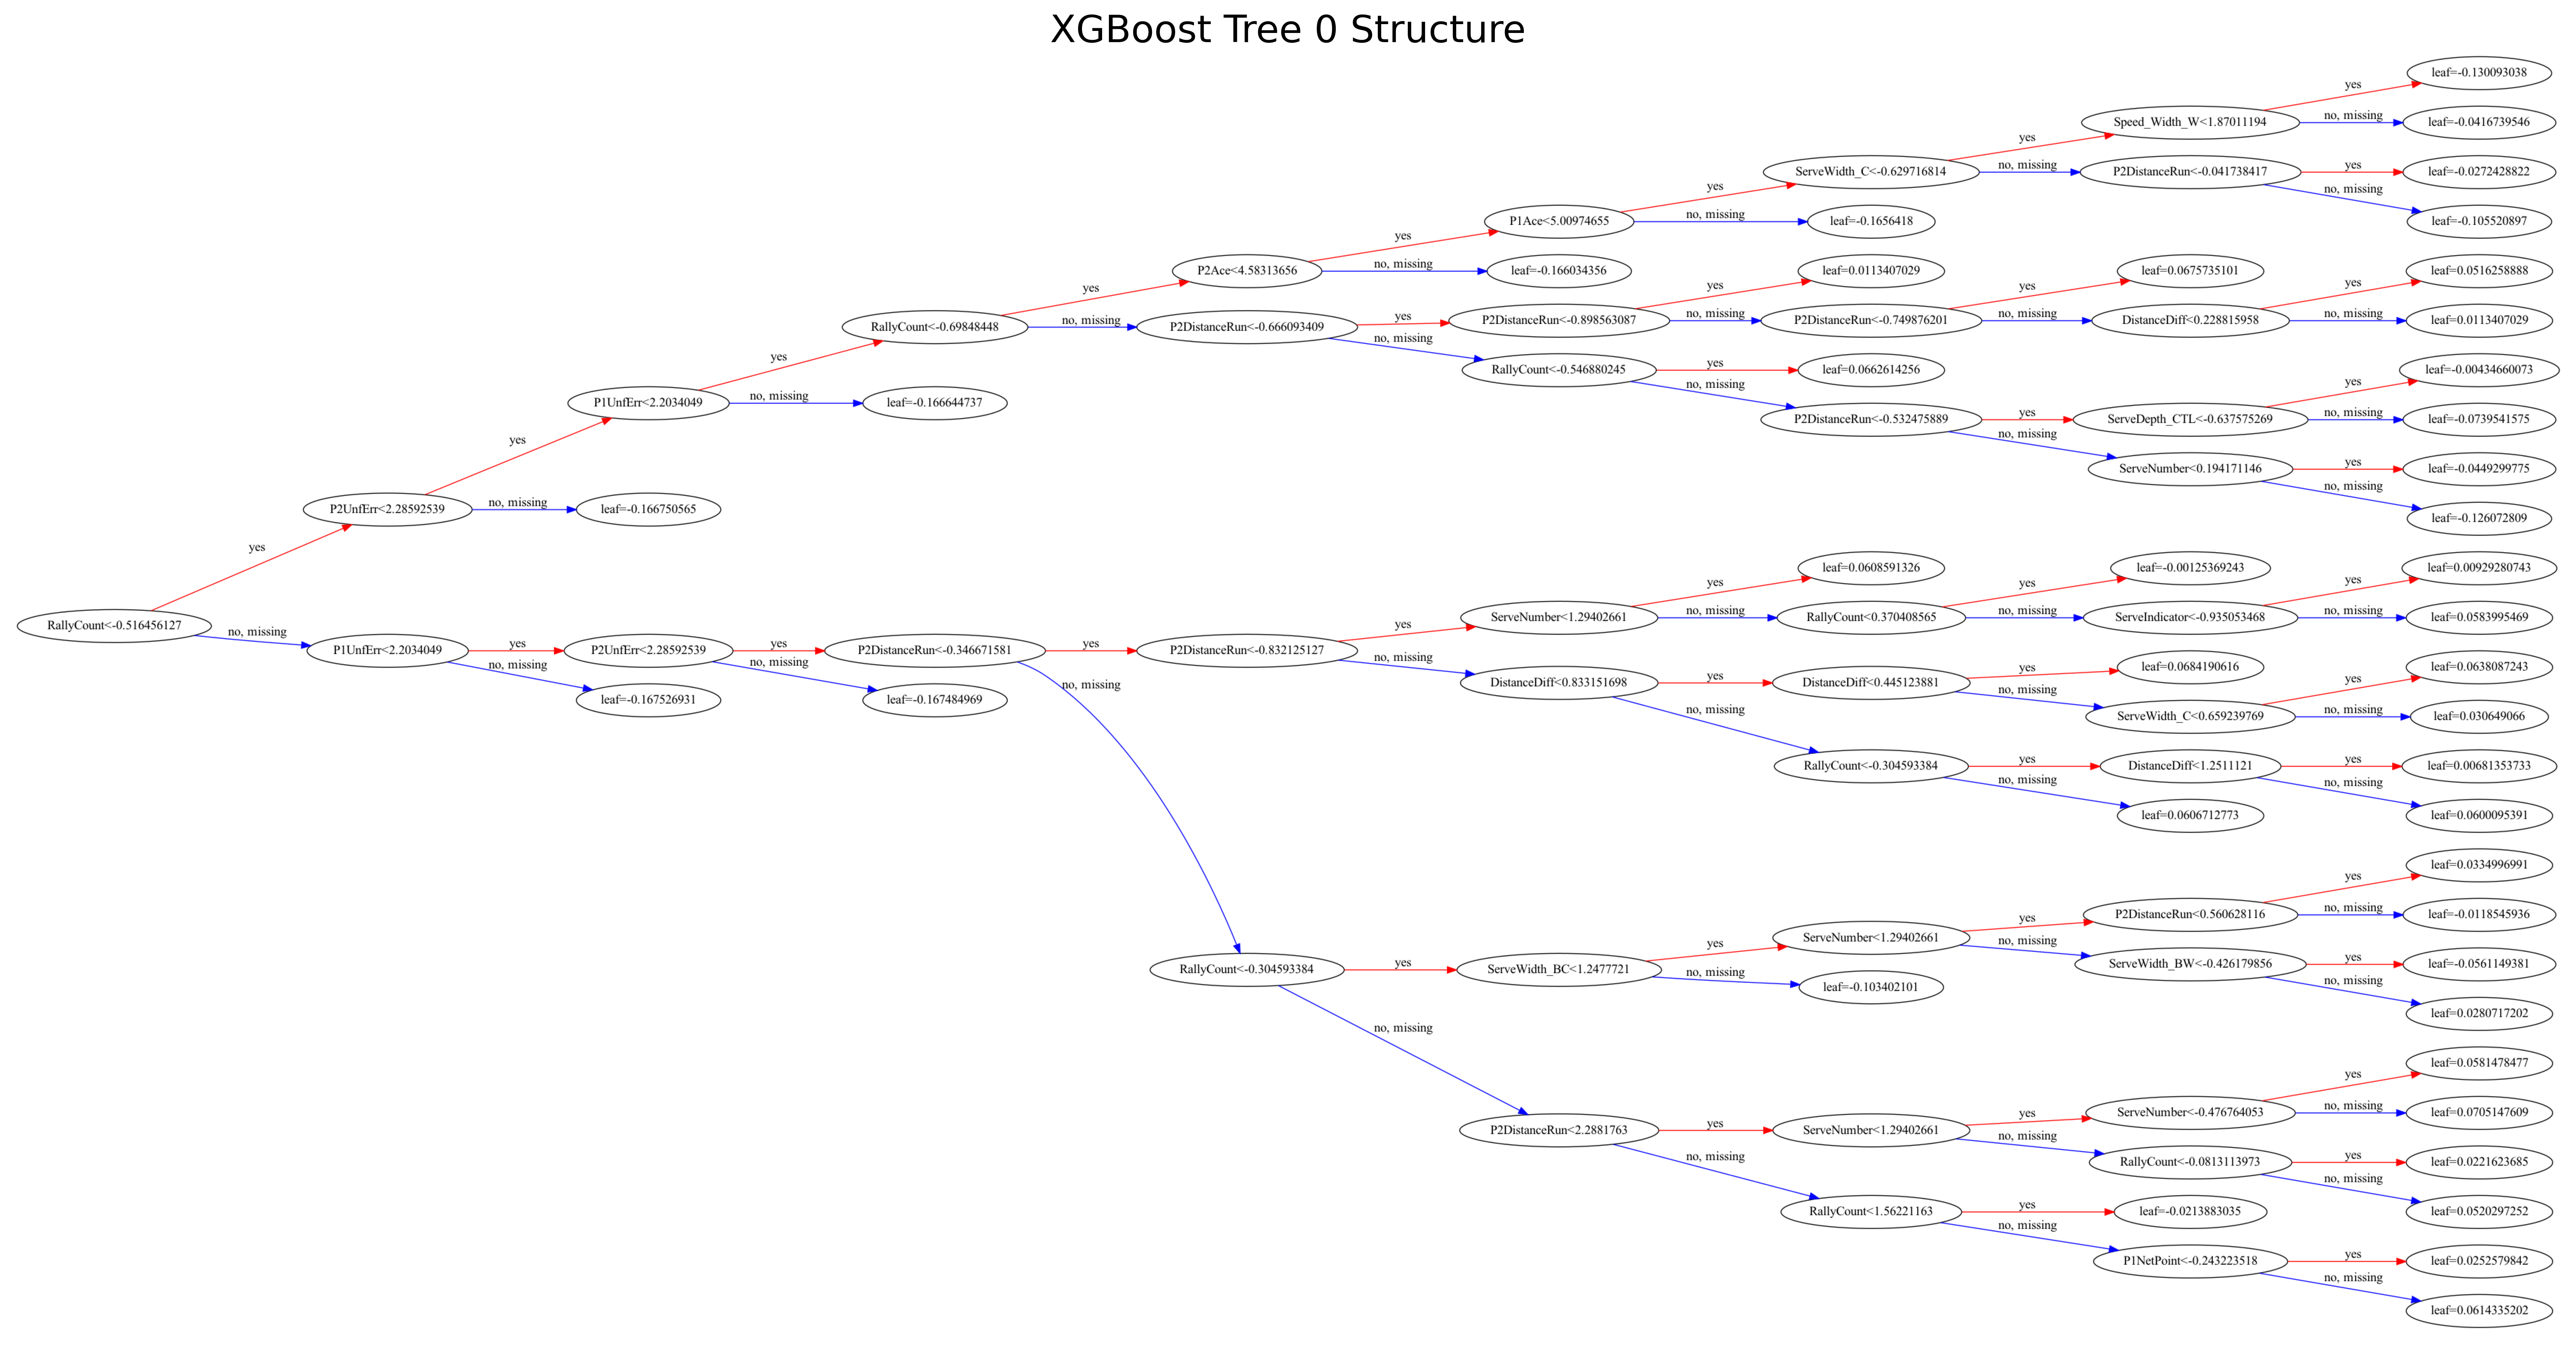

In [31]:
fig = plt.figure(figsize=(20, 10), dpi=400)
plot_tree(xgb_model, num_trees=0, rankdir='LR',ax=fig.gca())
plt.title("XGBoost Tree 0 Structure", fontsize=20)
plt.tight_layout()
plt.show()


## Model Comparision (Validation set)

In [32]:
# Extract relevant rows and columns from each classification report
models = {
    'Logistic Regression': logreg_report_df,
    'Random Forest': rf_report_df,
    'XGBoost': xgb_report_df,
    'LightGBM': lgb_report_df
}

# Build long-form rows for class 0 and class 1
rows = []
for model_name, report_df in models.items():
    for label in ['0', '1', 'accuracy']:
        row = report_df.loc[label, ['precision', 'recall', 'f1-score']]
        row.name = (model_name, f'{label}')
        rows.append(row)

# Combine into multi-index DataFrame
comparison_table = pd.DataFrame(rows)
comparison_table.index = pd.MultiIndex.from_tuples(comparison_table.index, names=['Validation Set Model', 'Class'])
comparison_table.columns = ['Precision', 'Recall', 'F1 Score']
comparison_table = comparison_table.round(3)
comparison_table


Precision  Recall  F1 Score
Validation Set Model Class                                
Logistic Regression  0             0.954   0.754     0.842
                     1             0.548   0.890     0.679
                     accuracy      0.789   0.789     0.789
Random Forest        0             0.952   0.776     0.855
                     1             0.569   0.883     0.692
                     accuracy      0.803   0.803     0.803
XGBoost              0             0.962   0.777     0.860
                     1             0.577   0.909     0.706
                     accuracy      0.810   0.810     0.810
LightGBM             0             0.928   0.838     0.881
                     1             0.625   0.807     0.704
                     accuracy      0.830   0.830     0.830

In [33]:
# # metrics = pd.DataFrame({
# #     'Logistic Regression': logreg_report_df.loc['1', ['precision', 'recall', 'f1-score']],
# #     'Random Forest': rf_report_df.loc['1', ['precision', 'recall', 'f1-score']],
# #     'XGBoost': xgb_report_df.loc['1', ['precision', 'recall', 'f1-score']],
# #     'LightGBM': lgb_report_df.loc['1', ['precision', 'recall', 'f1-score']]
# # })
# # metrics = metrics.T
# # metrics.plot(kind='bar', figsize=(10, 6))
# # plt.title('Model Comparison on Class 1 (Winner): Precision, Recall, F1 Score')
# # plt.ylabel('Score')
# # plt.ylim(0, 1)
# # plt.grid(axis='y')
# # plt.legend(title='Metric')
# # plt.tight_layout()
# # plt.show()
# # Reset and melt again
# # plot_df = comparison_table.reset_index()
# # plot_long_model = plot_df.melt(id_vars=['Model', 'Class'], var_name='Metric', value_name='Score')

# # plt.figure(figsize=(12, 6))
# # sns.catplot(data=plot_long_model, x='Model', y='Score', hue='Class', col='Metric',
# #             kind='bar', height=5, aspect=1.2, palette='Set2')

# # plt.subplots_adjust(top=0.85)
# # plt.suptitle('Performance by Model and Class')
# # plt.tight_layout()
# # plt.show()
# f1_scores = comparison_table['F1 Score'].unstack(level=1)

# # Plot
# f1_scores.plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e','#2ca02c'])
# plt.title('Model Comparison: F1 Score by Class')
# plt.ylabel('F1 Score')
# plt.ylim(0, 1)
# plt.xticks(rotation=45, ha='right')
# plt.grid(axis='y')
# plt.legend(title='Class')
# plt.tight_layout()
# plt.show()

/var/folders/h9/ww6bv2_56t3_2t6n6zljbkr40000gn/T/ipykernel_41202/673772220.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = val_df.groupby('RallyBin').agg({


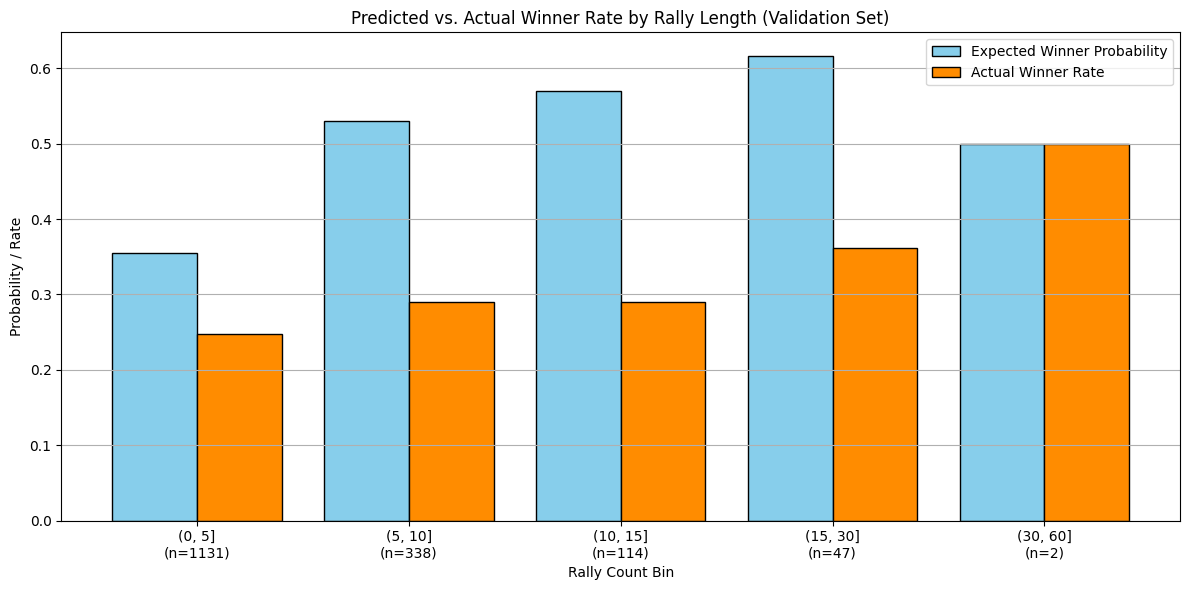

In [34]:
val_df = X_test.copy()
val_df['XWinner'] = y_pred
val_df['RallyCount'] = model_ready_data.loc[X_test.index, 'RallyCount'].values
val_df['RallyBin'] = pd.cut(val_df['RallyCount'], bins=[0, 5, 10, 15, 30, 60])
val_df['IsWinner'] = y_test
# print(val_df[val_df['RallyCount'] > 50]) 
# print(val_df['RallyBin'].value_counts())
# print(val_df.shape)
# print(val_df['RallyCount'].value_counts())
bin_summary = val_df.groupby('RallyBin').agg({
    'XWinner': 'mean',
    'IsWinner': 'mean'
})
bin_counts = val_df['RallyBin'].value_counts().sort_index()
labels_with_counts = [f"{bin}\n(n={count})" for bin, count in zip(bin_summary.index, bin_counts)]
plt.figure(figsize=(12, 6))
bar_width = 0.4

plt.bar(
    x=np.arange(len(bin_summary)) - bar_width / 2,
    height=bin_summary['XWinner'],
    width=bar_width,
    label='Expected Winner Probability',
    color='skyblue',
    edgecolor='black'
)
plt.bar(
    x=np.arange(len(bin_summary)) + bar_width / 2,
    height=bin_summary['IsWinner'],
    width=bar_width,
    label='Actual Winner Rate',
    color='darkorange',
    edgecolor='black'
)
plt.xticks(ticks=np.arange(len(bin_summary)), labels=labels_with_counts)
plt.ylabel('Probability / Rate')
plt.title('Predicted vs. Actual Winner Rate by Rally Length (Validation Set)')
plt.xlabel('Rally Count Bin')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()



RallyCount        521
P1DistanceRun     376
P2DistanceRun     369
Speed_KMH         323
DistanceDiff      203
P1UnfErr          116
ServeNumber        94
ServeIndicator     83
Speed_Width_W      82
ReturnDepth_D      81
P2UnfErr           78
P1Ace              75
UnfErrDiff         65
ServeWidth_BC      53
P2Ace              52
dtype: int32
ServeDepth_CTL         36
ReturnDepth_Missing    34
AceDiff                33
P2NetPoint             33
P1NetPoint             32
P2BreakPoint           26
ServeDepth_NCTL        18
NetDominance           15
P1BreakPoint           13
ServeWidth_W           11
P1BreakPointMissed      4
ServeWidth_Missing      3
ServeWidth_B            3
P2BreakPointMissed      2
ServeDepth_Missing      0
dtype: int32


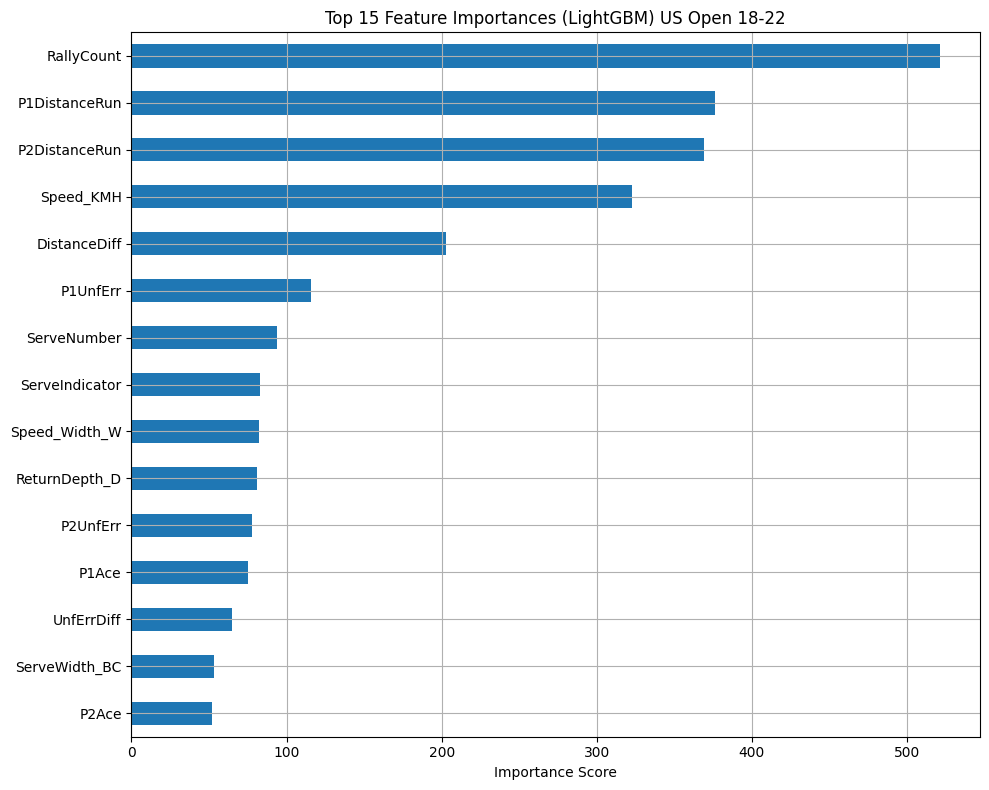

In [35]:
# Get feature importances as a Series
feature_importances = pd.Series(lgbm_model.feature_importances_, index=X.columns)
# Sort and select top 15
top_features = feature_importances.sort_values(ascending=False).head(15)
print(top_features)
bot_features = feature_importances.sort_values(ascending=False).tail(15)
print(bot_features)
plt.figure(figsize=(10, 8))
top_features.plot(kind='barh', title='Top 15 Feature Importances (LightGBM) US Open 18-22')
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

## TESTING

In [36]:
# Test set prep
X_test = test_ready_data[refined_features]
y_test = (test_ready_data['IsWinner']).astype(int)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)
print(X_test_scaled.shape)
# Predict probabilities on the test set using xgb
y_prob_test_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred_test_xgb = (y_prob_test_xgb >= best_threshold_xgb).astype(int)  #
test_report_xgb = classification_report(y_test, y_pred_test_xgb, output_dict=True)
test_report_df_xgb = pd.DataFrame(test_report_xgb).transpose()
test_auc_xgb = roc_auc_score(y_test, y_prob_test_xgb)
print("Test Set Performance (XGBoost):")
print(test_report_df_xgb)
print("Test AUC Score (XGBoost): " + str(test_auc_xgb))
#Predict probabilities on the test set using lgbm
y_prob_test_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]
y_pred_test_lgbm = (y_prob_test_lgbm >= best_threshold_lgbm).astype(int)  #
test_report_lgbm = classification_report(y_test, y_pred_test_lgbm, output_dict=True)
test_report_df_lgbm = pd.DataFrame(test_report_lgbm).transpose()
test_auc_lgbm = roc_auc_score(y_test, y_prob_test_lgbm)
print("Test Set Performance (LightGBM):")
print(test_report_df_lgbm)
print("Test AUC Score (LightGBM): " + str(test_auc_lgbm))
#Predict probabilities on the test set using logreg
y_prob_test_logreg = logreg.predict(X_test_scaled)
test_report_logreg = classification_report(y_test, y_prob_test_logreg, output_dict=True)
test_report_df_logreg = pd.DataFrame(test_report_logreg).transpose()
test_auc_logreg = roc_auc_score(y_test, y_prob_test_logreg)
print("Test Set Performance (Logistic Regression):")
print(test_report_df_logreg)
print("Test AUC Score (Logistic Regression): " + str(test_auc_logreg)) 
# Predict probabilities on the test set using rf
y_prob_test_rf = rf_model.predict(X_test_scaled)
test_report_rf = classification_report(y_test, y_prob_test_rf, output_dict=True)
test_report_df_rf = pd.DataFrame(test_report_rf).transpose()
test_auc_rf = roc_auc_score(y_test, y_prob_test_rf)
print("Test Set Performance (Random Forest):")
print(test_report_df_rf)
print("Test AUC Score (Random Forest): " + str(test_auc_rf))    

(1477, 33)
Test Set Performance (XGBoost):
              precision    recall  f1-score      support
0              0.955157  0.773140  0.854564  1102.000000
1              0.572650  0.893333  0.697917   375.000000
accuracy       0.803656  0.803656  0.803656     0.803656
macro avg      0.763903  0.833237  0.776240  1477.000000
weighted avg   0.858041  0.803656  0.814792  1477.000000
Test AUC Score (XGBoost): 0.9034434361766485
Test Set Performance (LightGBM):
              precision    recall  f1-score      support
0              0.923228  0.851180  0.885741  1102.000000
1              0.644252  0.792000  0.710526   375.000000
accuracy       0.836154  0.836154  0.836154     0.836154
macro avg      0.783740  0.821590  0.798134  1477.000000
weighted avg   0.852398  0.836154  0.841255  1477.000000
Test AUC Score (LightGBM): 0.9032909860859044
Test Set Performance (Logistic Regression):
              precision    recall  f1-score      support
0              0.958025  0.704174  0.811715  110

AUC Score: 0.9033


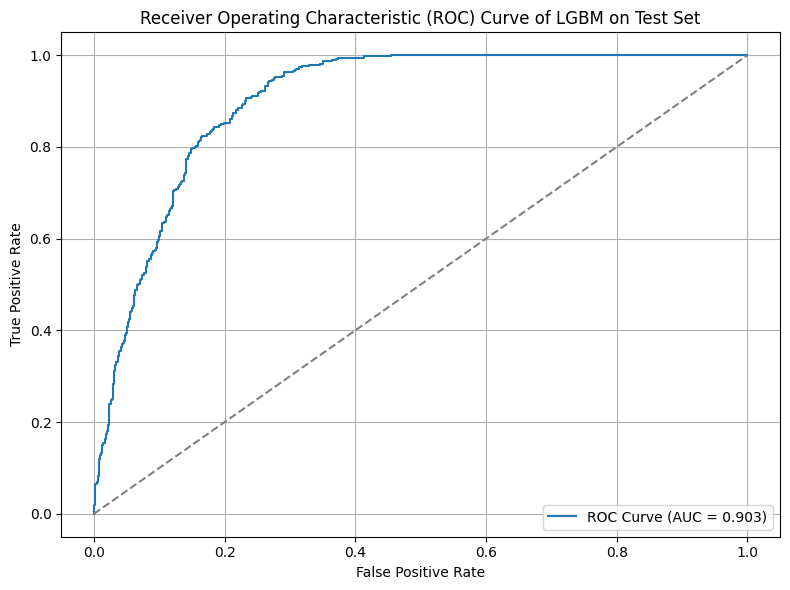

In [37]:
auc_score = roc_auc_score(y_test, y_prob_test_lgbm)
# auc = roc_auc_score(y_test, y_prob_lgbm)
print(f"AUC Score: {auc_score:.4f}")
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob_test_lgbm)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve of LGBM on Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

AUC Score: 0.9034


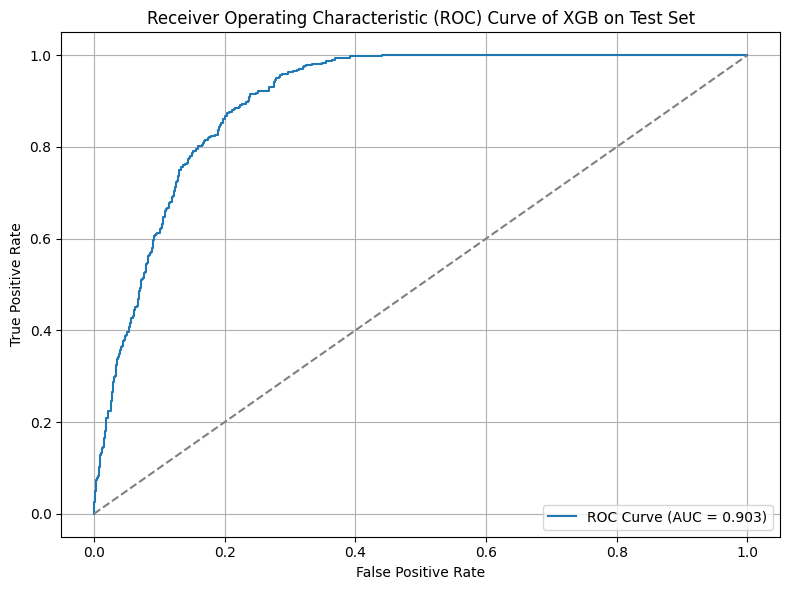

In [38]:
auc_score = roc_auc_score(y_test, y_prob_test_xgb)
# auc = roc_auc_score(y_test, y_prob_lgbm)
print(f"AUC Score: {auc_score:.4f}")
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob_test_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve of XGB on Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
## Model Comparision on Test Set
# Extract relevant rows and columns from each classification report
models = {
    'Logistic Regression': test_report_df_logreg,
    'Random Forest': test_report_df_rf,
    'XGBoost': test_report_df_xgb,
    'LightGBM': test_report_df_lgbm
}

# Build long-form rows for class 0 and class 1
rows = []
for model_name, report_df in models.items():
    for label in ['0', '1', 'accuracy']:
        row = report_df.loc[label, ['precision', 'recall', 'f1-score']]
        row.name = (model_name, f'{label}')
        rows.append(row)

# Combine into multi-index DataFrame
comparison_table = pd.DataFrame(rows)
comparison_table.index = pd.MultiIndex.from_tuples(comparison_table.index, names=['Test Set Model', 'Class'])
comparison_table.columns = ['Precision', 'Recall', 'F1 Score']
comparison_table = comparison_table.round(3)
comparison_table


Precision  Recall  F1 Score
Test Set Model      Class                                
Logistic Regression 0             0.958   0.704     0.812
                    1             0.511   0.909     0.655
                    accuracy      0.756   0.756     0.756
Random Forest       0             0.956   0.776     0.857
                    1             0.576   0.896     0.701
                    accuracy      0.806   0.806     0.806
XGBoost             0             0.955   0.773     0.855
                    1             0.573   0.893     0.698
                    accuracy      0.804   0.804     0.804
LightGBM            0             0.923   0.851     0.886
                    1             0.644   0.792     0.711
                    accuracy      0.836   0.836     0.836

### Feature Importance check

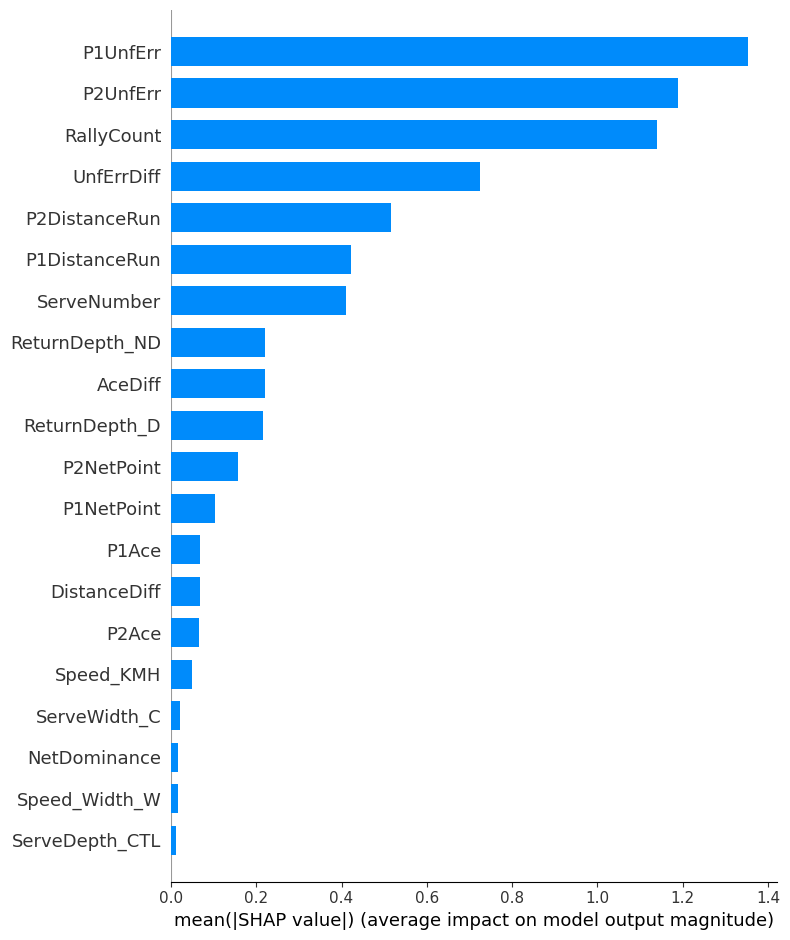

In [45]:
explainer = shap.Explainer(lgbm_model, X_train_resampled)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

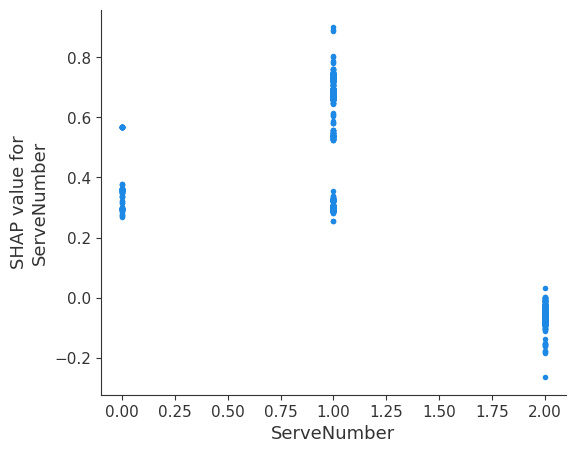

In [46]:
shap.dependence_plot(
    "ServeNumber",         # feature to plot
    shap_values.values, # SHAP values (numpy array)
    X_test,             # matching features
    interaction_index=None  # or set to another feature (e.g. 'rally_count')
)

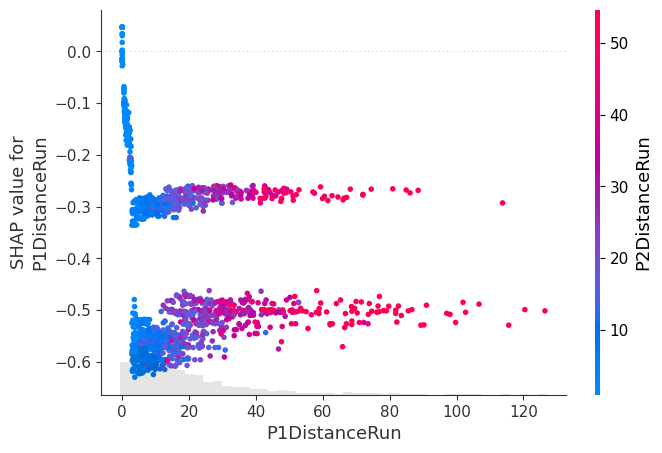

In [47]:
shap.plots.scatter(shap_values[:, "P1DistanceRun"], color=shap_values[:, "P2DistanceRun"])
# shap.plots.waterfall(shap_values[0], max_display=20)

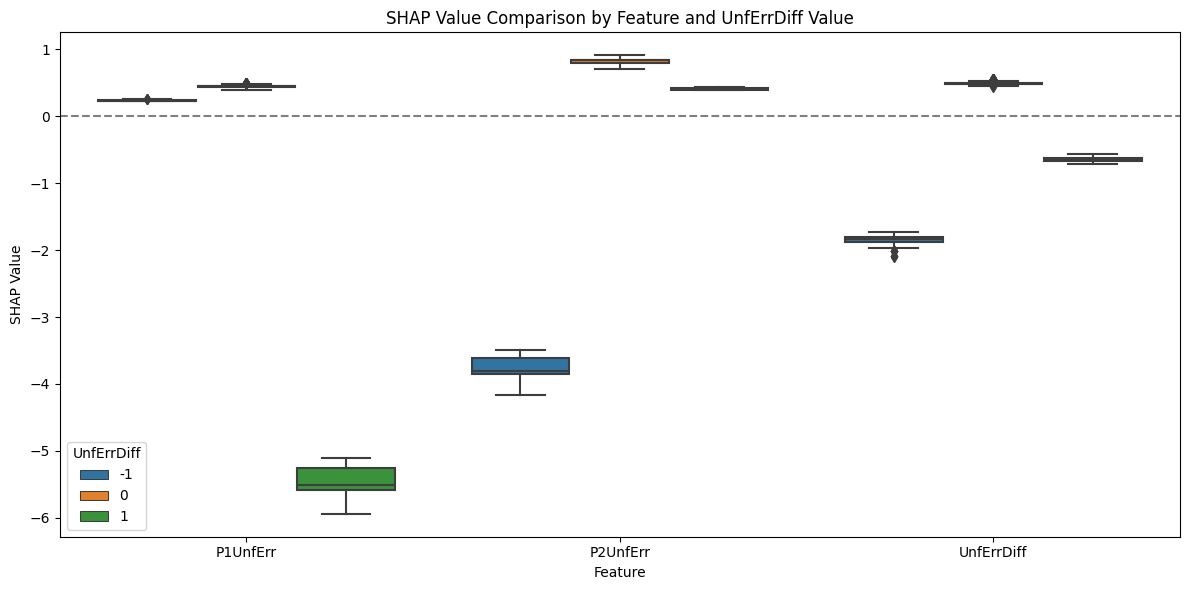

In [48]:
shap_df = pd.DataFrame({
    'P1UnfErr': shap_values[:, X_test.columns.get_loc("P1UnfErr")].values,
    'P2UnfErr': shap_values[:, X_test.columns.get_loc("P2UnfErr")].values,
    'UnfErrDiff': shap_values[:, X_test.columns.get_loc("UnfErrDiff")].values,
    'UnfErrDiff_value': X_test['UnfErrDiff'].values,
    'is_winner': y_test.values
})

# Reshape for seaborn boxplot
melted = pd.melt(
    shap_df,
    id_vars=['UnfErrDiff_value', 'is_winner'],
    value_vars=['P1UnfErr', 'P2UnfErr', 'UnfErrDiff'],
    var_name='Feature',
    value_name='SHAP_value'
)

# Plot SHAP value distributions grouped by UnfErrDiff
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted, x='Feature', y='SHAP_value', hue='UnfErrDiff_value')
plt.axhline(0, color='gray', linestyle='--')
plt.title("SHAP Value Comparison by Feature and UnfErrDiff Value")
plt.ylabel("SHAP Value")
plt.xlabel("Feature")
plt.legend(title='UnfErrDiff')
plt.tight_layout()
plt.show()


In [49]:
# Combine features and true label
X_test_with_label = X_test.copy()
X_test_with_label["is_winner"] = y_test


subset = X_test_with_label[(X_test_with_label["ReturnDepth_D"] == 0)]
# Choose features you want to inspect
features_to_view = [
    "UnfErrDiff", "is_winner", "RallyCount",
    "P1UnfErr", "P2UnfErr", "P1DistanceRun",
    "ServeNumber", "ReturnDepth_D", "ServeWidth_C"
]

# Display the top 10 rows
print(subset[features_to_view].head(10))

    UnfErrDiff  is_winner  RallyCount  P1UnfErr  P2UnfErr  P1DistanceRun  \
0            0          0           0         0         0          0.000   
1            0          0           0         0         0          0.000   
2            1          0           0         1         0          1.290   
3            0          0           5         0         0         26.758   
4            1          0           8         1         0         34.152   
5            0          0           1         0         0          5.890   
6            0          0           5         0         0         28.983   
7            0          1          15         0         0         61.122   
8            0          1          10         0         0         36.096   
10           0          0           1         0         0          0.663   

    ServeNumber  ReturnDepth_D  ServeWidth_C  
0             0            0.0           0.0  
1             0            0.0           0.0  
2             0       

## Visualizing the results using Precision, Recall and F1 Score vs Threshold

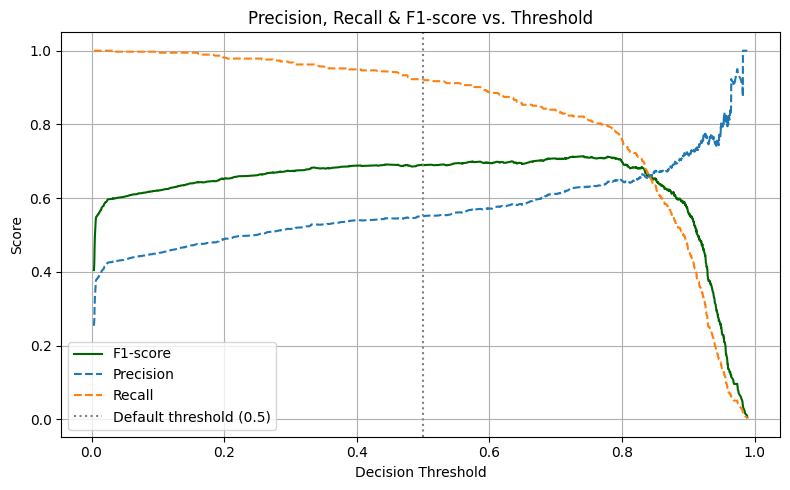

In [50]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_test_lgbm)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores[:-1], label="F1-score", color='darkgreen')
plt.plot(thresholds, precision[:-1], label="Precision", linestyle='--')
plt.plot(thresholds, recall[:-1], label="Recall", linestyle='--')
plt.axvline(0.5, color='gray', linestyle=':', label='Default threshold (0.5)')
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall & F1-score vs. Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

UnfErrDiff            0.214165
P2UnfErr              0.208738
P1UnfErr              0.190158
ServeWidth_Missing    0.060474
RallyCount            0.056540
P1Ace                 0.026711
P2Ace                 0.025700
AceDiff               0.018096
ServeWidth_C          0.016627
P1NetPoint            0.016151
ReturnDepth_ND        0.015280
P2DistanceRun         0.014361
P2NetPoint            0.013350
NetDominance          0.012897
ReturnDepth_D         0.011918
dtype: float32
ServeIndicator         0.007808
ServeDepth_NCTL        0.007635
ReturnDepth_Missing    0.007601
ServeWidth_BW          0.007112
Speed_KMH              0.007107
Speed_Width_W          0.006602
ServeDepth_CTL         0.005144
DistanceDiff           0.004499
P2BreakPointMissed     0.004146
ServeWidth_W           0.003783
P2BreakPoint           0.003683
P1BreakPoint           0.002801
P1BreakPointMissed     0.002410
ServeWidth_B           0.000525
ServeDepth_Missing     0.000000
dtype: float32


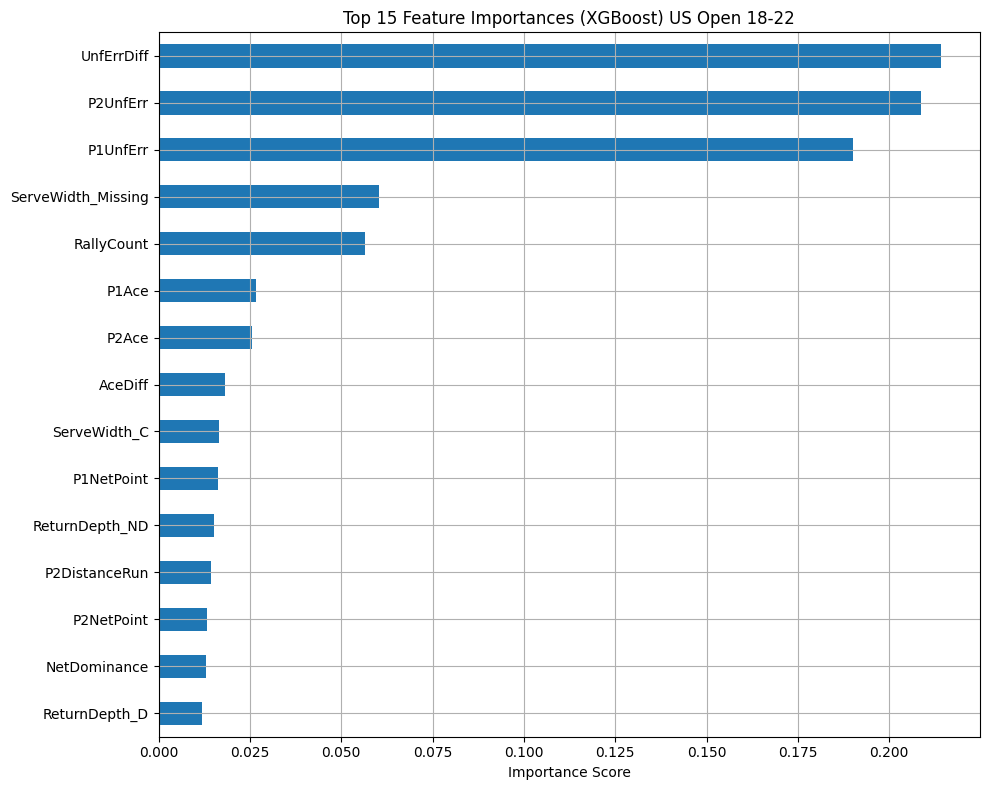

In [51]:
# Get feature importances as a Series
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_test.columns)
# Sort and select top 15
top_features = feature_importances.sort_values(ascending=False).head(15)
print(top_features)
bot_features = feature_importances.sort_values(ascending=False).tail(15)
print(bot_features)
plt.figure(figsize=(10, 8))
top_features.plot(kind='barh', title='Top 15 Feature Importances (XGBoost) US Open 18-22')
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

(1477, 36)


/var/folders/h9/ww6bv2_56t3_2t6n6zljbkr40000gn/T/ipykernel_41202/3657788660.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = val_df.groupby('RallyBin').agg({


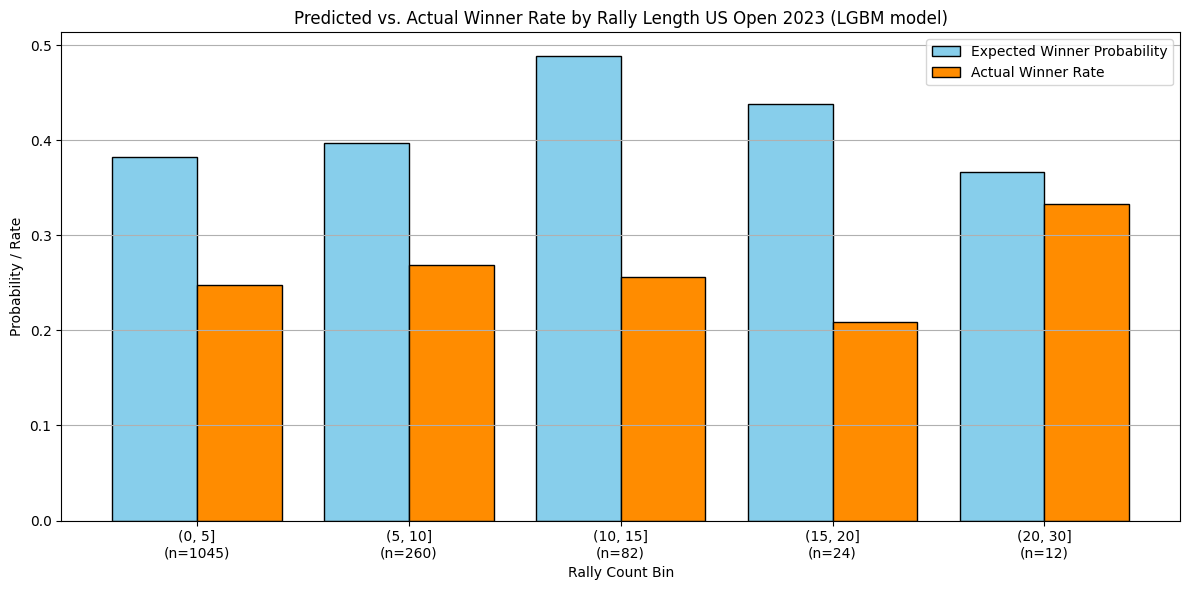

In [52]:
val_df = X_test.copy()
val_df['XWinner'] = y_prob_test_lgbm
val_df['RallyCount'] = model_ready_data.loc[X_test.index, 'RallyCount'].values
val_df['RallyBin'] = pd.cut(val_df['RallyCount'], bins=[0, 5, 10, 15, 20, 30])
val_df['IsWinner'] = y_test
# print(val_df[val_df['RallyCount'] > 50]) 
# print(val_df['RallyBin'].value_counts())
print(val_df.shape)
# print(val_df['RallyCount'].value_counts())
bin_summary = val_df.groupby('RallyBin').agg({
    'XWinner': 'mean',
    'IsWinner': 'mean'
})
bin_counts = val_df['RallyBin'].value_counts().sort_index()
labels_with_counts = [f"{bin}\n(n={count})" for bin, count in zip(bin_summary.index, bin_counts)]
plt.figure(figsize=(12, 6))
bar_width = 0.4

plt.bar(
    x=np.arange(len(bin_summary)) - bar_width / 2,
    height=bin_summary['XWinner'],
    width=bar_width,
    label='Expected Winner Probability',
    color='skyblue',
    edgecolor='black'
)
plt.bar(
    x=np.arange(len(bin_summary)) + bar_width / 2,
    height=bin_summary['IsWinner'],
    width=bar_width,
    label='Actual Winner Rate',
    color='darkorange',
    edgecolor='black'
)
plt.xticks(ticks=np.arange(len(bin_summary)), labels=labels_with_counts)
plt.ylabel('Probability / Rate')
plt.title('Predicted vs. Actual Winner Rate by Rally Length US Open 2023 (LGBM model)')
plt.xlabel('Rally Count Bin')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

